In [296]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import IterativeImputer
!pip install lime

In [297]:
file_path = '/content/drive/MyDrive/btcusdt/BTCUSDT-30m-2020-07.csv'
column_names = [
    'open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_volume', 'count', 'taker_buy_volume',
    'taker_buy_quote_volume', 'ignore'
]
df = pd.read_csv(file_path, names=column_names)
file_path = '/content/drive/MyDrive/btcusdt/BTCUSDT-30m-2021-04.csv'
column_names = [
    'open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_volume', 'count', 'taker_buy_volume',
    'taker_buy_quote_volume', 'ignore'
]
df1= pd.read_csv(file_path, names=column_names)
df = pd.concat([df, df1], ignore_index=True)
df2=df

In [298]:
df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume',
       'ignore'],
      dtype='object')

In [299]:
df.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1593561600000,9138.88,9138.88,9101.00,9121.28,5139.545,1593563399999,4.685838e+07,13992,2405.528,2.193170e+07,0
1,1593563400000,9121.28,9128.19,9090.00,9123.29,3500.470,1593565199999,3.189012e+07,9828,1427.287,1.300624e+07,0
2,1593565200000,9123.29,9132.46,9105.50,9105.51,2139.000,1593566999999,1.950404e+07,6763,829.202,7.561380e+06,0
3,1593567000000,9105.51,9127.63,9101.22,9124.50,1468.890,1593568799999,1.339340e+07,4607,778.042,7.093991e+06,0
4,1593568800000,9124.50,9147.00,9114.02,9137.04,3188.520,1593570599999,2.912732e+07,8700,1669.889,1.525495e+07,0


In [300]:

def feature_engineering(df):
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df=df.drop(['ignore'],axis=1)
    df['ROC_30min'] = df['close'].pct_change(periods=1) * 100
    df['price_rate_of_change'] = df['close'].pct_change() * 100
    df['daily_price_change'] = df['close'].diff()
    df['log_returns'] = df['close'].pct_change().apply(lambda x: np.log(1 + x))
    df['volume_rate_of_change'] = df['volume'].pct_change() * 100
    df['on_balance_volume'] = df['volume'] * np.sign(df['close'].diff()).cumsum()
    df['accumulation_distribution'] = (df['close'] - df['low']) / (df['high'] - df['low']) * df['volume']
    rolling_window = 20
    df['historical_volatility'] = df['log_returns'].rolling(window=rolling_window).std() * np.sqrt(252)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df['hour_of_day'] = df['open_time'].dt.hour
    df['day_of_week'] = df['open_time'].dt.dayofweek
    df['month'] = df['open_time'].dt.month
    df['year'] = df['open_time'].dt.year
    rolling_window_stats = 20
    df['rolling_mean'] = df['close'].rolling(window=rolling_window_stats).mean()
    df['rolling_std'] = df['close'].rolling(window=rolling_window_stats).std()
    df['kurtosis'] = df['log_returns'].rolling(window=rolling_window_stats).kurt()
    df['skewness'] = df['log_returns'].rolling(window=rolling_window_stats).skew()
    df['autocorrelation'] = df['log_returns'].autocorr()
    short_window = 3
    long_window = 30
    df['short_mavg'] = df['close'].rolling(window=short_window).mean()
    df['long_mavg'] = df['close'].rolling(window=long_window).mean()
    df['price_to_volume_ratio'] = df['close'] / df['volume']
    lag_periods = 1
    df['lagged_close'] = df['close'].shift(lag_periods)
    df['lagged_volume'] = df['volume'].shift(lag_periods)
    window=14
    df['diff'] = df['close'].diff()
    df['gain'] = np.where(df['diff'] > 0, df['diff'], 0)
    df['loss'] = np.where(df['diff'] < 0, -df['diff'], 0)
    avg_gain = df['gain'].rolling(window=14, min_periods=1).mean()
    avg_loss = df['loss'].rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df = df.drop(['diff', 'gain', 'loss'], axis=1)

    return df
df = feature_engineering(df)
print(df.head())

            open_time     open     high      low    close    volume  \
0 2020-07-01 00:00:00  9138.88  9138.88  9101.00  9121.28  5139.545   
1 2020-07-01 00:30:00  9121.28  9128.19  9090.00  9123.29  3500.470   
2 2020-07-01 01:00:00  9123.29  9132.46  9105.50  9105.51  2139.000   
3 2020-07-01 01:30:00  9105.51  9127.63  9101.22  9124.50  1468.890   
4 2020-07-01 02:00:00  9124.50  9147.00  9114.02  9137.04  3188.520   

               close_time  quote_volume  count  taker_buy_volume  ...  \
0 2020-07-01 00:29:59.999  4.685838e+07  13992          2405.528  ...   
1 2020-07-01 00:59:59.999  3.189012e+07   9828          1427.287  ...   
2 2020-07-01 01:29:59.999  1.950404e+07   6763           829.202  ...   
3 2020-07-01 01:59:59.999  1.339340e+07   4607           778.042  ...   
4 2020-07-01 02:29:59.999  2.912732e+07   8700          1669.889  ...   

   rolling_std  kurtosis  skewness  autocorrelation   short_mavg  long_mavg  \
0          NaN       NaN       NaN         0.003704    

In [301]:
def add_signals(data, rsi_period=14, short_window=12, long_window=26, signal_col='signal'):
    data_copy = data.copy()
    data_copy[signal_col] = 0
    data_copy.loc[data_copy['RSI'] < 30, signal_col] = 1
    data_copy.loc[data_copy['RSI'] > 70, signal_col] = -1
    data_copy['macd'] = data_copy['short_mavg'] - data_copy['long_mavg']
    data_copy.loc[data_copy['macd'] > 0, signal_col] = 1
    data_copy.loc[data_copy['macd'] < 0, signal_col] = -1

    return data_copy
df = add_signals(df, rsi_period=14, short_window=12, long_window=26, signal_col='signal')
print(df.head())


            open_time     open     high      low    close    volume  \
0 2020-07-01 00:00:00  9138.88  9138.88  9101.00  9121.28  5139.545   
1 2020-07-01 00:30:00  9121.28  9128.19  9090.00  9123.29  3500.470   
2 2020-07-01 01:00:00  9123.29  9132.46  9105.50  9105.51  2139.000   
3 2020-07-01 01:30:00  9105.51  9127.63  9101.22  9124.50  1468.890   
4 2020-07-01 02:00:00  9124.50  9147.00  9114.02  9137.04  3188.520   

               close_time  quote_volume  count  taker_buy_volume  ...  \
0 2020-07-01 00:29:59.999  4.685838e+07  13992          2405.528  ...   
1 2020-07-01 00:59:59.999  3.189012e+07   9828          1427.287  ...   
2 2020-07-01 01:29:59.999  1.950404e+07   6763           829.202  ...   
3 2020-07-01 01:59:59.999  1.339340e+07   4607           778.042  ...   
4 2020-07-01 02:29:59.999  2.912732e+07   8700          1669.889  ...   

   skewness  autocorrelation   short_mavg  long_mavg  price_to_volume_ratio  \
0       NaN         0.003704          NaN        NaN   

In [302]:
df.head(2)

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,...,skewness,autocorrelation,short_mavg,long_mavg,price_to_volume_ratio,lagged_close,lagged_volume,RSI,signal,macd
0,2020-07-01 00:00:00,9138.88,9138.88,9101.0,9121.28,5139.545,2020-07-01 00:29:59.999,4.685838e+07,13992,2405.528,...,NaN,0.003704,NaN,NaN,1.774725,NaN,NaN,NaN,0,NaN
1,2020-07-01 00:30:00,9121.28,9128.19,9090.0,9123.29,3500.470,2020-07-01 00:59:59.999,3.189012e+07,9828,1427.287,...,NaN,0.003704,NaN,NaN,2.606304,9121.28,5139.545,100.0,-1,NaN


In [303]:
def impute_numerical_columns(df, numerical_columns):
    df = df.drop(df.index[:1])
    print("NaN values before imputation:")
    print(df.isnull().sum())
    imputer_numeric = IterativeImputer(max_iter=100, tol=1e-3, random_state=0)
    df_imputed = pd.DataFrame(imputer_numeric.fit_transform(df[numerical_columns]), columns=numerical_columns)
    df_imputed = pd.concat([df_imputed, df.drop(columns=numerical_columns)], axis=1)
    print("\nNaN values after imputation:")
    print(df_imputed.isnull().sum())
    df_imputed = df_imputed.drop(df_imputed.index[-1])
    df_imputed = df_imputed.drop(['open_time', 'close_time'], axis=1)
    return df_imputed

numerical_columns = df.select_dtypes(include=[np.number]).columns
df_imputed = impute_numerical_columns(df, numerical_columns)
print("\nUpdated DataFrame:")
print(df_imputed.head())
dg=df_imputed.drop(['macd','year','RSI','month','autocorrelation'],axis=1)

NaN values before imputation:
open_time                     0
open                          0
high                          0
low                           0
close                         0
volume                        0
close_time                    0
quote_volume                  0
count                         0
taker_buy_volume              0
taker_buy_quote_volume        0
ROC_30min                     0
price_rate_of_change          0
daily_price_change            0
log_returns                   0
volume_rate_of_change         0
on_balance_volume             0
accumulation_distribution     0
historical_volatility        19
hour_of_day                   0
day_of_week                   0
month                         0
year                          0
rolling_mean                 18
rolling_std                  18
kurtosis                     19
skewness                     19
autocorrelation               0
short_mavg                    1
long_mavg                    28
price_to_v

## **Training**

In [304]:
dg.columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'count',
       'taker_buy_volume', 'taker_buy_quote_volume', 'ROC_30min',
       'price_rate_of_change', 'daily_price_change', 'log_returns',
       'volume_rate_of_change', 'on_balance_volume',
       'accumulation_distribution', 'historical_volatility', 'hour_of_day',
       'day_of_week', 'rolling_mean', 'rolling_std', 'kurtosis', 'skewness',
       'short_mavg', 'long_mavg', 'price_to_volume_ratio', 'lagged_close',
       'lagged_volume', 'signal'],
      dtype='object')

In [305]:
X = dg.drop(['signal'], axis=1)
y = dg['signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
nn_classifier = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, activation='relu', random_state=42)
stacking_classifier = StackingClassifier(
    estimators=[
        ('rf', rf_classifier),
        ('gb', gb_classifier),
        ('nn', nn_classifier)
    ],
    final_estimator=LogisticRegression(),
    stack_method='auto',
)
rf_classifier.fit(X_train_scaled, y_train)
gb_classifier.fit(X_train_scaled, y_train)
nn_classifier.fit(X_train_scaled, y_train)
stacking_classifier.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_classifier.predict(X_test_scaled)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f'Stacking Ensemble Accuracy: {accuracy_stacking}')



Stacking Ensemble Accuracy: 0.9283276450511946


#**Explaning**

MLP classifier


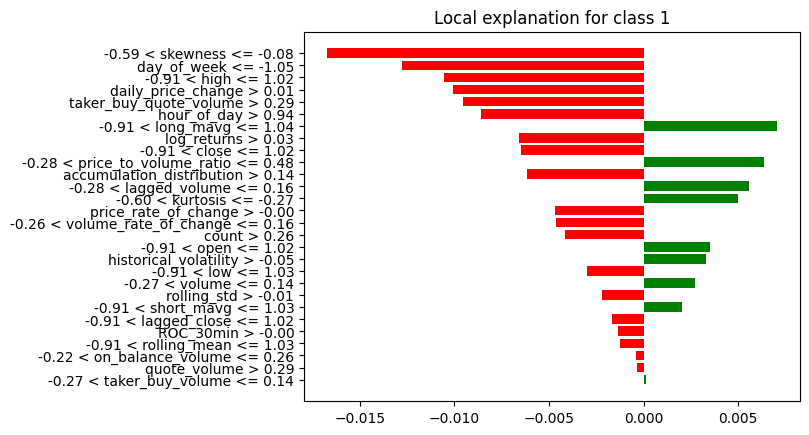

In [326]:
import lime
import lime.lime_tabular
instance_to_explain = X_test_scaled[0]
lime_explainer_nn = lime.lime_tabular.LimeTabularExplainer(X_train_scaled,
                                                           training_labels=y_train,
                                                           feature_names=X.columns,
                                                           mode='classification')
lime_nn_explanation = lime_explainer_nn.explain_instance(instance_to_explain,
                                                         nn_classifier.predict_proba,
                                                         num_features=len(X.columns))
lime_nn_explanation.as_list()
lime_nn_explanation.as_pyplot_figure()
plt.show()

Random forest


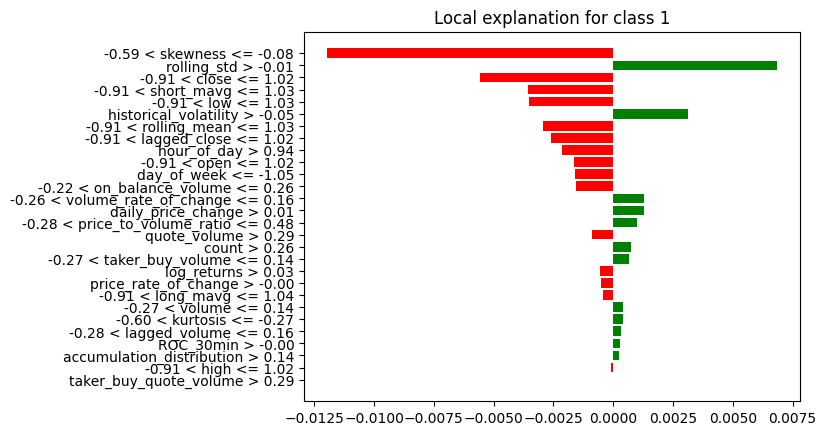

In [327]:
lime_explainer_rf = lime.lime_tabular.LimeTabularExplainer(X_train_scaled,
                                                           training_labels=y_train,
                                                           feature_names=X.columns,
                                                           mode='classification')
instance_to_explain = X_test_scaled[0]
lime_rf_explanation = lime_explainer_rf.explain_instance(instance_to_explain,
                                                         rf_classifier.predict_proba,
                                                         num_features=len(X.columns))
lime_rf_explanation.as_list()
lime_rf_explanation.as_pyplot_figure()
plt.show()

GradientBoosting

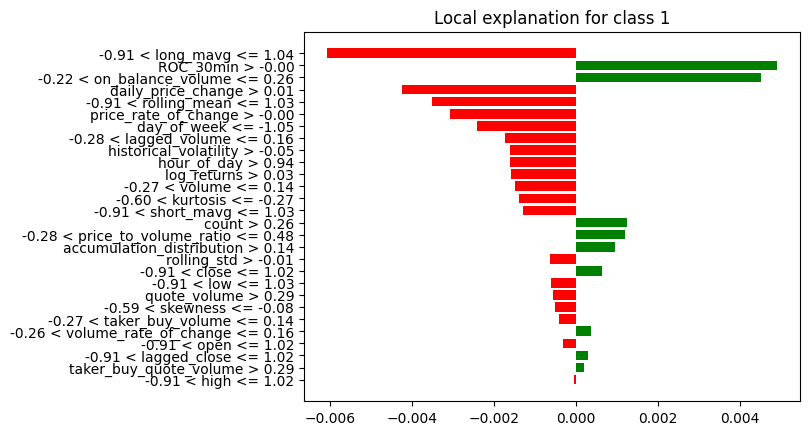

In [328]:
lime_explainer_gb = lime.lime_tabular.LimeTabularExplainer(X_train_scaled,
                                                           training_labels=y_train,
                                                           feature_names=X.columns,
                                                           mode='classification')
lime_gb_explanation = lime_explainer_gb.explain_instance(instance_to_explain,
                                                         gb_classifier.predict_proba,
                                                         num_features=len(X.columns))
lime_gb_explanation.as_pyplot_figure()
plt.show()


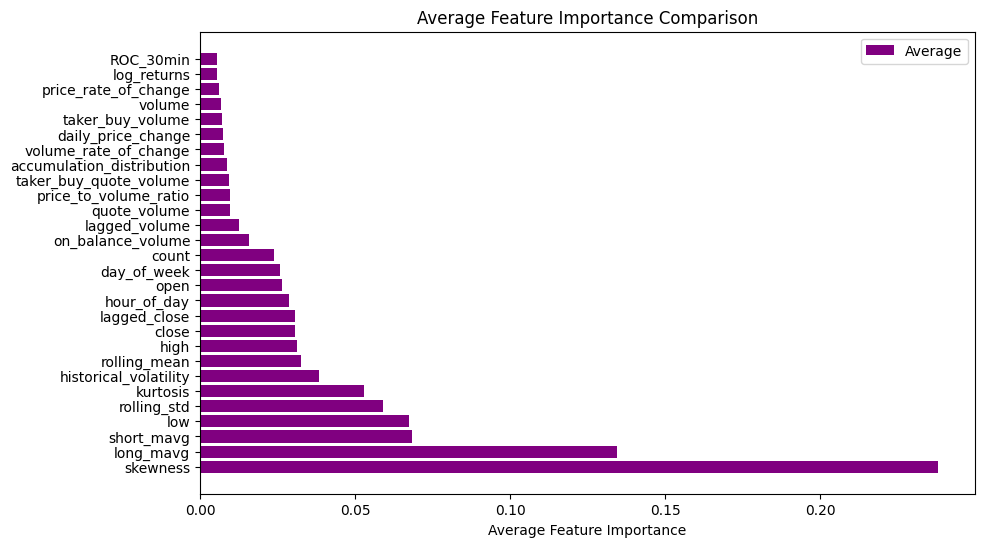

In [306]:
import matplotlib.pyplot as plt
rf_feature_importance = rf_classifier.feature_importances_
gb_feature_importance = gb_classifier.feature_importances_
assert len(rf_feature_importance) == len(X.columns)
assert len(gb_feature_importance) == len(X.columns)
lr_coefficients = stacking_classifier.final_estimator_.coef_
average_importance = (rf_feature_importance + gb_feature_importance) / 2
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RandomForest': rf_feature_importance,
    'GradientBoosting': gb_feature_importance,
    'Average': average_importance
})
sorted_df = feature_importance_df.sort_values(by='Average', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(sorted_df['Feature'], sorted_df['Average'], color='purple', label='Average')
plt.xlabel('Average Feature Importance')
plt.title('Average Feature Importance Comparison')
plt.legend()
plt.show()


# **Backtesting**

In [309]:
initial_balance = balance = 100000
transaction_cost_rate = 0.0015
slippage = 0.002
reward_to_risk_ratio = 2
trailing_stoploss_percent = 1
trailing_stoploss_triggered = False

stop_loss_price = take_profit_price = entry_price = stop_loss = take_profit = 0
position_open = False

total_trades = gross_profit = gross_loss = winning_trades = losing_trades = 0
max_drawdown = current_drawdown = max_dip = average_dip = 0
max_duration_time = 0
holding_duration = []
dates = []
trade_actions = []
trade_returns = []

current_position = buy_signal_index = None
y_pred=y_pred_stacking
risk_per_trade = 0.02  # 2% of total capital per trade
max_loss_per_trade = initial_balance * risk_per_trade
max_allowable_drawdown = 5

for i in range(len(y_pred)):
    if y_pred[i] == 1 and balance > 0 and current_position != 'Buy':  # Buy signal
        entry_price = X_test['close'].iloc[i]
        take_profit_price = entry_price * (1 + reward_to_risk_ratio)
        stop_loss_price = entry_price * (1 - reward_to_risk_ratio / 2)  # 2:1 risk-reward ratio
        balance *= (1 - transaction_cost_rate)  # Apply transaction cost
        balance *= (1 - slippage)  # Apply slippage
        dates.append(X_test.index[i])
        trade_actions.append('Buy')
        buy_signal_index = i
        trailing_stoploss_triggered = False
        current_position = 'Buy'
    elif y_pred[i] == -1 and current_position == 'Buy':  # Sell signal
        balance *= (1 - transaction_cost_rate)  # Apply transaction cost
        balance *= (1 - slippage)  # Apply slippage
        dates.append(X_test.index[i])

        # Check if the protective stop-loss condition is met
        if (X_test['close'].iloc[i] / entry_price - 1) * 100 < -max_allowable_drawdown:
            trade_actions.append('Sell (Protective Stop-loss)')
            trade_returns.append(-max_allowable_drawdown)  # Record the protective stop-loss as the return
        else:
            trade_actions.append('Sell')
            if trailing_stoploss_triggered:
                trade_returns.append((X_test['close'].iloc[i] / stop_loss_price - 1) * 100)
            else:
                trade_returns.append((X_test['close'].iloc[i] / entry_price - 1) * 100)

        current_position = None
        if buy_signal_index is not None:
            holding_duration.append((i - buy_signal_index) * 30)
            max_duration_time = max(max_duration_time, (i - buy_signal_index) * 30)

# **Parameters**

In [310]:
total_returns = (balance / initial_balance - 1) * 100
total_buy_signals = y_pred.tolist().count(1)
winning_trades = sum([1 for ret in trade_returns if ret > 0])
winning_trades_percentage = (winning_trades / total_buy_signals) * 100
gross_profit = sum([ret for ret in trade_returns if ret > 0])
gross_loss = sum([abs(ret) for ret in trade_returns if ret < 0])
net_profit = gross_profit - gross_loss
average_winning_trade = gross_profit / winning_trades if winning_trades > 0 else 0
average_losing_trade = gross_loss / (total_buy_signals - winning_trades) if total_buy_signals - winning_trades > 0 else 0
daily_returns = np.diff(balance * (X_test['close'] / X_test['close'].iloc[0])) / (balance * (X_test['close'] / X_test['close'].iloc[0]))[:-1]
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * (252 ** 0.5)
downside_returns = [ret for ret in daily_returns if ret < 0]
sortino_ratio = (np.mean(daily_returns) / np.std(downside_returns)) * (252 ** 0.5) if len(downside_returns) > 0 else 0
average_holding_duration = np.mean(holding_duration) if len(holding_duration) > 0 else 0
max_dip = min(trade_returns) if len(trade_returns) > 0 else 0
average_dip = np.mean([ret for ret in trade_returns if ret < 0]) if len([ret for ret in trade_returns if ret < 0]) > 0 else 0
cumulative_returns = np.cumsum(trade_returns)
peak_value = np.maximum.accumulate(cumulative_returns)
drawdowns = (peak_value - cumulative_returns) / peak_value
max_drawdown = np.max(drawdowns)
buy_and_hold_return = (X_test['close'].iloc[-1] / X_test['close'].iloc[0] - 1) * 100
net_profit_exceeding_benchmark = net_profit - buy_and_hold_return
percentage_of_model_benchmark = (net_profit_exceeding_benchmark / buy_and_hold_return) * 100


# Print performance metrics
print(f'Net Profit: {net_profit:.2f} USDT')
print(f'Gross Profit: {gross_profit:.2f} USDT')
print(f'Gross Loss: {gross_loss:.2f} USDT')
print(f'Total Closed Trades: {total_buy_signals}')
print(f'Win Rate (Profitability %): {winning_trades_percentage:.2f}%')
print(f'Max Drawdown: {max_drawdown:.2f}%')
print(f'Average Winning Trade: {average_winning_trade:.2f} USDT')
print(f'Average Losing Trade: {average_losing_trade:.2f} USDT')
print(f'Buy and Hold Return of BTC: {buy_and_hold_return:.2f}%')
print(f'Largest Losing Trade: {min(trade_returns):.2f} USDT')
print(f'Largest Winning Trade: {max(trade_returns):.2f} USDT')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sortino_ratio:.2f}')
print(f'Average Holding Duration per Trade: {average_holding_duration:.2f} minutes')
print(f'Max Dip in Running Trade: {max_dip:.2f}%')
print(f'Average Dip in Running Trade: {average_dip:.2f}%')
print(f'Max Duration Time of Single Trade: {max_duration_time:.2f} minutes')
print(f"Percentage Outperformance: {percentage_of_model_benchmark:.2f}%")

Net Profit: 20607.66 USDT
Gross Profit: 20946.99 USDT
Gross Loss: 339.33 USDT
Total Closed Trades: 318
Win Rate (Profitability %): 21.38%
Max Drawdown: 0.05%
Average Winning Trade: 308.04 USDT
Average Losing Trade: 1.36 USDT
Buy and Hold Return of BTC: 9.14%
Largest Losing Trade: -5.00 USDT
Largest Winning Trade: 561.67 USDT
Sharpe Ratio: 7.05
Sortino Ratio: 41.79
Average Holding Duration per Trade: 62.78 minutes
Max Dip in Running Trade: -5.00%
Average Dip in Running Trade: -4.09%
Max Duration Time of Single Trade: 240.00 minutes
Percentage Outperformance: 225326.73%


OUT OF **Sample** 1

In [311]:
import pandas as pd
file_path = '/content/drive/MyDrive/btcusdt/BTCUSDT-30m-2022-03.csv'
df= pd.read_csv(file_path)

In [ ]:
df = feature_engineering(df)
print(df.head())

In [ ]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
df_imputed = impute_numerical_columns(df, numerical_columns)
print("\nUpdated DataFrame:")
print(df_imputed.head())
dg=df_imputed.drop(['year','RSI','month','autocorrelation'],axis=1)

In [315]:
new_data_scaled = scaler.transform(dg)
new_data_predictions = stacking_classifier.predict(new_data_scaled)

In [317]:
initial_balance = balance = 100000
transaction_cost_rate = 0.0015
slippage = 0.002
reward_to_risk_ratio = 2
trailing_stoploss_percent = 0.001
trailing_stoploss_triggered = False

stop_loss_price = take_profit_price = entry_price = stop_loss = take_profit = 0
position_open = False

total_trades = gross_profit = gross_loss = winning_trades = losing_trades = 0
max_drawdown = current_drawdown = max_dip = average_dip = 0
max_duration_time = 0
holding_duration = []
dates = []
trade_actions = []
trade_returns = []

current_position = buy_signal_index = None
X_test=dg
y_pred=new_data_predictions
risk_per_trade = 0.02  # 2% of total capital per trade
max_loss_per_trade = initial_balance * risk_per_trade
max_allowable_drawdown = 0.7

for i in range(len(y_pred)):
    if y_pred[i] == 1 and balance > 0 and current_position != 'Buy':  # Buy signal
        entry_price = X_test['close'].iloc[i]
        take_profit_price = entry_price * (1 + reward_to_risk_ratio)
        stop_loss_price = entry_price * (1 - reward_to_risk_ratio / 2)  # 2:1 risk-reward ratio
        balance *= (1 - transaction_cost_rate)  # Apply transaction cost
        balance *= (1 - slippage)  # Apply slippage
        dates.append(X_test.index[i])
        trade_actions.append('Buy')
        buy_signal_index = i
        trailing_stoploss_triggered = False
        current_position = 'Buy'
    elif y_pred[i] == -1 and current_position == 'Buy':  # Sell signal
        balance *= (1 - transaction_cost_rate)  # Apply transaction cost
        balance *= (1 - slippage)  # Apply slippage
        dates.append(X_test.index[i])

        # Check if the protective stop-loss condition is met
        if (X_test['close'].iloc[i] / entry_price - 1) * 100 < -max_allowable_drawdown:
            trade_actions.append('Sell (Protective Stop-loss)')
            trade_returns.append(-max_allowable_drawdown)  # Record the protective stop-loss as the return
        else:
            trade_actions.append('Sell')
            if trailing_stoploss_triggered:
                trade_returns.append((X_test['close'].iloc[i] / stop_loss_price - 1) * 100)
            else:
                trade_returns.append((X_test['close'].iloc[i] / entry_price - 1) * 100)

        current_position = None
        if buy_signal_index is not None:
            holding_duration.append((i - buy_signal_index) * 30)
            max_duration_time = max(max_duration_time, (i - buy_signal_index) * 30)

**Parameters**

In [318]:
total_returns = (balance / initial_balance - 1) * 100
total_buy_signals = y_pred.tolist().count(1)
winning_trades = sum([1 for ret in trade_returns if ret > 0])
winning_trades_percentage = (winning_trades / total_buy_signals) * 100
gross_profit = sum([ret for ret in trade_returns if ret > 0])
gross_loss = sum([abs(ret) for ret in trade_returns if ret < 0])
net_profit = gross_profit - gross_loss
average_winning_trade = gross_profit / winning_trades if winning_trades > 0 else 0
average_losing_trade = gross_loss / (total_buy_signals - winning_trades) if total_buy_signals - winning_trades > 0 else 0
daily_returns = np.diff(balance * (X_test['close'] / X_test['close'].iloc[0])) / (balance * (X_test['close'] / X_test['close'].iloc[0]))[:-1]
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * (252 ** 0.5)
downside_returns = [ret for ret in daily_returns if ret < 0]
sortino_ratio = (np.mean(daily_returns) / np.std(downside_returns)) * (252 ** 0.5) if len(downside_returns) > 0 else 0
average_holding_duration = np.mean(holding_duration) if len(holding_duration) > 0 else 0
max_dip = min(trade_returns) if len(trade_returns) > 0 else 0
average_dip = np.mean([ret for ret in trade_returns if ret < 0]) if len([ret for ret in trade_returns if ret < 0]) > 0 else 0
cumulative_returns = np.cumsum(trade_returns)
peak_value = np.maximum.accumulate(cumulative_returns)
drawdowns = (peak_value - cumulative_returns) / peak_value
max_drawdown = np.max(drawdowns)
buy_and_hold_return = (X_test['close'].iloc[-1] / X_test['close'].iloc[0] - 1) * 100
net_profit_exceeding_benchmark = net_profit - buy_and_hold_return
percentage_of_model_benchmark = (net_profit_exceeding_benchmark / buy_and_hold_return) * 100


# Print performance metrics
print(f'Net Profit: {net_profit:.2f} USDT')
print(f'Gross Profit: {gross_profit:.2f} USDT')
print(f'Gross Loss: {gross_loss:.2f} USDT')
print(f'Total Closed Trades: {total_buy_signals}')
print(f'Win Rate (Profitability %): {winning_trades_percentage:.2f}%')
print(f'Max Drawdown: {max_drawdown:.2f}%')
print(f'Average Winning Trade: {average_winning_trade:.2f} USDT')
print(f'Average Losing Trade: {average_losing_trade:.2f} USDT')
print(f'Buy and Hold Return of BTC: {buy_and_hold_return:.2f}%')
print(f'Largest Losing Trade: {min(trade_returns):.2f} USDT')
print(f'Largest Winning Trade: {max(trade_returns):.2f} USDT')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sortino_ratio:.2f}')
print(f'Average Holding Duration per Trade: {average_holding_duration:.2f} minutes')
print(f'Max Dip in Running Trade: {max_dip:.2f}%')
print(f'Average Dip in Running Trade: {average_dip:.2f}%')
print(f'Max Duration Time of Single Trade: {max_duration_time:.2f} minutes')
print(f"Percentage Outperformance: {percentage_of_model_benchmark:.2f}%")

Net Profit: 23.22 USDT
Gross Profit: 46.34 USDT
Gross Loss: 23.12 USDT
Total Closed Trades: 887
Win Rate (Profitability %): 5.98%
Max Drawdown: 17.81%
Average Winning Trade: 0.87 USDT
Average Losing Trade: 0.03 USDT
Buy and Hold Return of BTC: 4.49%
Largest Losing Trade: -0.70 USDT
Largest Winning Trade: 7.60 USDT
Sharpe Ratio: 0.14
Sortino Ratio: 0.19
Average Holding Duration per Trade: 246.39 minutes
Max Dip in Running Trade: -0.70%
Average Dip in Running Trade: -0.42%
Max Duration Time of Single Trade: 1950.00 minutes
Percentage Outperformance: 416.62%


OUT OF SAMPLE **2**

In [319]:
file_path = '/content/drive/MyDrive/btcusdt/BTCUSDT-30m-2023-02.csv'
df= pd.read_csv(file_path)

In [ ]:
df = feature_engineering(df)
print(df.head())

In [ ]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
df_imputed = impute_numerical_columns(df, numerical_columns)
print("\nUpdated DataFrame:")
print(df_imputed.head())
dg=df_imputed.drop(['year','RSI','month','autocorrelation'],axis=1)

In [323]:
new_data_scaled = scaler.transform(dg)
new_data_predictions = stacking_classifier.predict(new_data_scaled)

In [324]:
initial_balance = balance = 100000
transaction_cost_rate = 0.0015
slippage = 0.002
reward_to_risk_ratio = 2
trailing_stoploss_percent = 0.001
trailing_stoploss_triggered = False

stop_loss_price = take_profit_price = entry_price = stop_loss = take_profit = 0
position_open = False

total_trades = gross_profit = gross_loss = winning_trades = losing_trades = 0
max_drawdown = current_drawdown = max_dip = average_dip = 0
max_duration_time = 0
holding_duration = []
dates = []
trade_actions = []
trade_returns = []

current_position = buy_signal_index = None
X_test=dg
y_pred=new_data_predictions
risk_per_trade = 0.02
max_loss_per_trade = initial_balance * risk_per_trade
max_allowable_drawdown = 0.7

for i in range(len(y_pred)):
    if y_pred[i] == 1 and balance > 0 and current_position != 'Buy':
        entry_price = X_test['close'].iloc[i]
        take_profit_price = entry_price * (1 + reward_to_risk_ratio)
        stop_loss_price = entry_price * (1 - reward_to_risk_ratio / 2)  # 2:1 risk-reward ratio
        balance *= (1 - transaction_cost_rate)  # Apply transaction cost
        balance *= (1 - slippage)  # Apply slippage
        dates.append(X_test.index[i])
        trade_actions.append('Buy')
        buy_signal_index = i
        trailing_stoploss_triggered = False
        current_position = 'Buy'
    elif y_pred[i] == -1 and current_position == 'Buy':  # Sell signal
        balance *= (1 - transaction_cost_rate)  # Apply transaction cost
        balance *= (1 - slippage)  # Apply slippage
        dates.append(X_test.index[i])

        # Check if the protective stop-loss condition is met
        if (X_test['close'].iloc[i] / entry_price - 1) * 100 < -max_allowable_drawdown:
            trade_actions.append('Sell (Protective Stop-loss)')
            trade_returns.append(-max_allowable_drawdown)  # Record the protective stop-loss as the return
        else:
            trade_actions.append('Sell')
            if trailing_stoploss_triggered:
                trade_returns.append((X_test['close'].iloc[i] / stop_loss_price - 1) * 100)
            else:
                trade_returns.append((X_test['close'].iloc[i] / entry_price - 1) * 100)

        current_position = None
        if buy_signal_index is not None:
            holding_duration.append((i - buy_signal_index) * 30)
            max_duration_time = max(max_duration_time, (i - buy_signal_index) * 30)

In [325]:
total_returns = (balance / initial_balance - 1) * 100
total_buy_signals = y_pred.tolist().count(1)
winning_trades = sum([1 for ret in trade_returns if ret > 0])
winning_trades_percentage = (winning_trades / total_buy_signals) * 100
gross_profit = sum([ret for ret in trade_returns if ret > 0])
gross_loss = sum([abs(ret) for ret in trade_returns if ret < 0])
net_profit = gross_profit - gross_loss
average_winning_trade = gross_profit / winning_trades if winning_trades > 0 else 0
average_losing_trade = gross_loss / (total_buy_signals - winning_trades) if total_buy_signals - winning_trades > 0 else 0
daily_returns = np.diff(balance * (X_test['close'] / X_test['close'].iloc[0])) / (balance * (X_test['close'] / X_test['close'].iloc[0]))[:-1]
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * (252 ** 0.5)
downside_returns = [ret for ret in daily_returns if ret < 0]
sortino_ratio = (np.mean(daily_returns) / np.std(downside_returns)) * (252 ** 0.5) if len(downside_returns) > 0 else 0
average_holding_duration = np.mean(holding_duration) if len(holding_duration) > 0 else 0
max_dip = min(trade_returns) if len(trade_returns) > 0 else 0
average_dip = np.mean([ret for ret in trade_returns if ret < 0]) if len([ret for ret in trade_returns if ret < 0]) > 0 else 0
cumulative_returns = np.cumsum(trade_returns)
peak_value = np.maximum.accumulate(cumulative_returns)
drawdowns = (peak_value - cumulative_returns) / peak_value
max_drawdown = np.max(drawdowns)
buy_and_hold_return = (X_test['close'].iloc[-1] / X_test['close'].iloc[0] - 1) * 100
net_profit_exceeding_benchmark = net_profit - buy_and_hold_return
percentage_of_model_benchmark = (net_profit_exceeding_benchmark / buy_and_hold_return) * 100


# Print performance metrics
print(f'Net Profit: {net_profit:.2f} USDT')
print(f'Gross Profit: {gross_profit:.2f} USDT')
print(f'Gross Loss: {gross_loss:.2f} USDT')
print(f'Total Closed Trades: {total_buy_signals}')
print(f'Win Rate (Profitability %): {winning_trades_percentage:.2f}%')
print(f'Max Drawdown: {max_drawdown:.2f}%')
print(f'Average Winning Trade: {average_winning_trade:.2f} USDT')
print(f'Average Losing Trade: {average_losing_trade:.2f} USDT')
print(f'Buy and Hold Return of BTC: {buy_and_hold_return:.2f}%')
print(f'Largest Losing Trade: {min(trade_returns):.2f} USDT')
print(f'Largest Winning Trade: {max(trade_returns):.2f} USDT')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sortino_ratio:.2f}')
print(f'Average Holding Duration per Trade: {average_holding_duration:.2f} minutes')
print(f'Max Dip in Running Trade: {max_dip:.2f}%')
print(f'Average Dip in Running Trade: {average_dip:.2f}%')
print(f'Max Duration Time of Single Trade: {max_duration_time:.2f} minutes')
print(f"Percentage Outperformance: {percentage_of_model_benchmark:.2f}%")

Net Profit: 13.54 USDT
Gross Profit: 20.17 USDT
Gross Loss: 6.63 USDT
Total Closed Trades: 1296
Win Rate (Profitability %): 0.46%
Max Drawdown: 0.64%
Average Winning Trade: 3.36 USDT
Average Losing Trade: 0.01 USDT
Buy and Hold Return of BTC: 0.23%
Largest Losing Trade: -0.70 USDT
Largest Winning Trade: 11.49 USDT
Sharpe Ratio: 0.04
Sortino Ratio: 0.05
Average Holding Duration per Trade: 1606.96 minutes
Max Dip in Running Trade: -0.70%
Average Dip in Running Trade: -0.39%
Max Duration Time of Single Trade: 8040.00 minutes
Percentage Outperformance: 5750.06%
